In [1]:
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter

# doc2vec tool
import gensim
from gensim.models import doc2vec

# sklearn classification 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Prepraring for classifiaction

## Computing new cells

In [2]:
# loading data
reviews_df = pd.read_csv('./data/reviews_clean.csv',
                        converters={'Review_lemmatized': pd.eval}) # just this used
                        #converters={'Review_lemmatized': pd.eval, 'Review_stopwords': pd.eval, 'Review_bigrams': pd.eval})

In [3]:
reviews_df

,Review,Rating,Review_processed,Review_lemmatized,Review_stopwords,Review_bigrams
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...","['nice', 'hotel', 'expensive', 'parking', 'got...","[('nice', 'hotel'), ('hotel', 'expensive'), ('..."
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...","['ok', 'nothing', 'special', 'charge', 'diamon...","[('ok', 'nothing'), ('nothing', 'special'), ('..."
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not experience hotel monaco seattl...,"[nice, room, not, experience, hotel, monaco, s...","['nice', 'room', 'experience', 'hotel', 'monac...","[('nice', 'room'), ('room', 'experience'), ('e..."
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ...","['unique', 'great', 'stay', 'wonderful', 'time...","[('unique', 'great'), ('great', 'stay'), ('sta..."
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game...","['great', 'stay', 'great', 'stay', 'went', 'se...","[('great', 'stay'), ('stay', 'great'), ('great..."
...,...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best kept secret rd time staying charm not sta...,"[best, kept, secret, rd, time, staying, charm,...","['best', 'kept', 'secret', 'rd', 'time', 'stay...","[('best', 'kept'), ('kept', 'secret'), ('secre..."
20487,great location price view hotel great quick pl...,4,great location price view hotel great quick pl...,"[great, location, price, view, hotel, great, q...","['great', 'location', 'price', 'view', 'hotel'...","[('great', 'location'), ('location', 'price'),..."
20488,"ok just looks nice modern outside, desk staff ...",2,ok just looks nice modern outside desk staff n...,"[ok, just, look, nice, modern, outside, desk, ...","['ok', 'look', 'nice', 'modern', 'outside', 'd...","[('ok', 'look'), ('look', 'nice'), ('nice', 'm..."
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruined vacation hotel opened sept ...,"[hotel, theft, ruined, vacation, hotel, opened...","['hotel', 'theft', 'ruined', 'vacation', 'hote...","[('hotel', 'theft'), ('theft', 'ruined'), ('ru..."


In [4]:
# getting reviews' length
reviews_df['words_number'] = reviews_df.Review_lemmatized.apply(lambda x: len(x))

In [5]:
# getting reviews' commas number
reviews_df['commas'] = reviews_df.Review.apply(lambda review_text: review_text.count(','))

In [6]:
# computing average length of a sentence
# there are no '.' so I use ','
# not sure if it should be used since there are no stopwors
# it also has a bug :D, it counts spaces and there is always an extra one 
reviews_df['average_length'] = reviews_df.Review.apply(lambda review_text: np.mean([len(sentence.split(' ')) for sentence in review_text.split(',')]))

In [7]:
# TODO: optimize
all_words = []

for rev in reviews_df.Review_lemmatized:
    all_words.extend(rev)
    
len(all_words)

2092254

In [10]:
# analizing word occurence number
word_occurence_number = pd.DataFrame.from_dict(Counter(all_words), orient='index')

word_occurence_number.describe()

,0
count,71900.000000
mean,29.099499
std,414.316660
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,52901.000000


In [11]:
np.mean(reviews_df.words_number)

102.105997755112

## Dov2vec

In [79]:
# function to measure doc2vec performce
# by analizing the most similar (the nearest 50) vectors
def measure_doc2vec_performence(doc2vec_model):
    ratings = []

    for tag in range(50):
        similar_reviews = doc2vec_model.dv.most_similar([str(tag)])

        r = [reviews_df.Rating.iloc[tag]]
        for review_index, _ in similar_reviews:
            r.append(reviews_df.Rating.iloc[int(review_index)])

        ratings.append(r)

    ratings = np.array(ratings)

    mean_of_similar = [np.mean(similar_ratings) for similar_ratings in ratings[: , 1:]]
    return mean_absolute_error(ratings[:, 0], mean_of_similar)
    

In [16]:
tagged_words = [doc2vec.TaggedDocument(words=review, tags=[str(i)]) for i, review in enumerate(reviews_df.Review_lemmatized)]

In [17]:
# increased to obtain better performce
n_epochs = 32
# the 75% value
# maybe it is even to high, gonna just after performence
# but this will include around 25 % of the occuring words
min_count = 5
# there are no stop words so the window should not be to big
window_size = 2

In [84]:
# looking for best vector size
old_score = 10000

for v_size in range(16, 64, 4):
    doc2vec_model = doc2vec.Doc2Vec(vector_size=v_size, min_count=min_count, epochs=n_epochs, window=window_size)
    doc2vec_model.build_vocab(tagged_words)
    doc2vec_model.train(tagged_words, total_examples=doc2vec_model.corpus_count, epochs=n_epochs)
    doc2vec_model.save("doc2vec-vec32-window2.model")

    new_score = measure_doc2vec_performence(doc2vec_model)
    
    print(f"For vector size {v_size} the score is: {new_score}")
    if new_score < old_score:
        print(old_score)
        best_v_size = v_size
        old_score = new_score

For vector size 16 the score is: 0.602
10000
For vector size 20 the score is: 0.628
For vector size 24 the score is: 0.5780000000000001
0.602
For vector size 28 the score is: 0.5159999999999999
0.5780000000000001
For vector size 32 the score is: 0.5319999999999999
For vector size 36 the score is: 0.5959999999999999
For vector size 40 the score is: 0.5059999999999999
0.5159999999999999
For vector size 44 the score is: 0.608
For vector size 48 the score is: 0.5900000000000001
For vector size 52 the score is: 0.642
For vector size 56 the score is: 0.634
For vector size 60 the score is: 0.622


In [85]:
# usually different results
# almost good, way more computionaly efficient
vector_size = 28

In [86]:
# training the doc2vec model
doc2vec_model = doc2vec.Doc2Vec(vector_size=v_size, min_count=min_count, epochs=n_epochs, window=window_size)
doc2vec_model.build_vocab(tagged_words)
doc2vec_model.train(tagged_words, total_examples=doc2vec_model.corpus_count, epochs=n_epochs)
doc2vec_model.save("doc2vec-vec32-window2.model")

### Trying to verify if the doc2vec embedding worked out

In [87]:
ratings = []
for tag in range(20):
    similar_reviews = doc2vec_model.dv.most_similar([str(tag)])

    r = [reviews_df.Rating.iloc[tag]]
    for review_index, _ in similar_reviews:
        r.append(reviews_df.Rating.iloc[int(review_index)])

    ratings.append(r)

ratings = np.array(ratings)

In [88]:
# closer evaluation of the doc2vec 
for rating in ratings:
    print(f"The review with rating {rating[0]} has similiar documents with mean rating: {np.mean(rating[1:])}")

The review with rating 4 has similiar documents with mean rating: 3.7
The review with rating 2 has similiar documents with mean rating: 2.4
The review with rating 3 has similiar documents with mean rating: 3.1
The review with rating 5 has similiar documents with mean rating: 4.7
The review with rating 5 has similiar documents with mean rating: 3.4
The review with rating 5 has similiar documents with mean rating: 4.1
The review with rating 5 has similiar documents with mean rating: 4.1
The review with rating 4 has similiar documents with mean rating: 3.5
The review with rating 5 has similiar documents with mean rating: 4.8
The review with rating 5 has similiar documents with mean rating: 4.8
The review with rating 2 has similiar documents with mean rating: 3.0
The review with rating 4 has similiar documents with mean rating: 3.9
The review with rating 4 has similiar documents with mean rating: 4.0
The review with rating 3 has similiar documents with mean rating: 2.5
The review with rati

In [89]:
# TO DELETE?
# is it working? a normal sence with stopwords and all the other
vector_good = doc2vec_model.infer_vector('Nice open space area. Comfy and relaxing atmosphere. People very cheerful'.split())
vector_bad = doc2vec_model.infer_vector('Discousting food and a lot time to wait for service, unpolite service'.split())
vector_neutral = doc2vec_model.infer_vector('Very nice hotel in bad neighbourhood'.split())

In [90]:
# TO DELETE?
good_review_index = int(doc2vec_model.dv.most_similar(vector_good)[0][0])
reviews_df.Review.iloc[good_review_index], reviews_df.Rating.iloc[good_review_index]

('cosy hotel nice area great hotel stay cosy good location good staff knowledgeable english, no faults, cosy rooms comfortable bed, clean, good choice paris, recommend hotel friends,  ',
 5)

In [91]:
# TO DELETE?
bad_review_index = int(doc2vec_model.dv.most_similar(vector_bad)[3][0])
reviews_df.Review.iloc[bad_review_index], reviews_df.Rating.iloc[bad_review_index]

("n't believe bad review hotel, 2nd time resort, food service staff great, beach die rooms spotless, read reviews remember people hard, reviews good true, people forget change food alot sun good drinks day cause sick feel like crap, blame resort, oh people say poor country appalled islands poor, homework, dominicans nice people, dominican 6 times past 6 years sick slow day, love iberostar chain, year like try ibero costa dorada, reviews good resort, ibero la romana hacienda dominicus love, slow enjoy,  ",
 5)

In [92]:
# adding the word embedding as a new column
reviews_df['doc2vec'] = reviews_df.Review_lemmatized.apply(lambda text_list: list(doc2vec_model.infer_vector(text_list)))

In [109]:
# creating a dataframe with just used columns
reviews_for_classification = reviews_df[['Review', 'Review_lemmatized', 'doc2vec', 'commas', 'words_number', 'average_length', 'Rating']]

In [110]:
# saving as csv for faster use in future
reviews_for_classification.to_csv('./data/reviews_for_classifiaction.csv', index=False)

### Loading data

In [95]:
reviews_for_classification = pd.read_csv("reviews_for_classifiaction.csv", 
                                        converters={'Review_lemmatized': pd.eval, 'doc2vec': pd.eval})

# Classifiaction

In [96]:
# function for ploting confusion matrix with heatmap by seaborn
def plot_confusion_matrix(y_true, y_pred):
    confusion_M = confusion_M = confusion_matrix(y_true, y_pred)
    possible_reviews = range(1,6)
    confusion_M_df = pd.DataFrame(confusion_M, columns=possible_reviews, index=possible_reviews)

    sn.heatmap(confusion_M_df, annot=True, fmt='g', annot_kws={"size": 10}) 

## SVM Classifier

### Classification just on the embedded document
Viviani said on the lecture that while doing classification we should also consider the number of commas, average word length ans ect.

#### Preparing training and test set

In [97]:
# checking if everything is alrigth 
# to delete later
len(reviews_for_classification.doc2vec.iloc[0]) == v_size

False

In [98]:
# deviding the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews_for_classification.doc2vec.to_list(), 
                                                    reviews_for_classification.Rating, 
                                                    test_size=0.1,
                                                    random_state=42)

In [99]:
len(X_train), len(y_train), len(X_test), len(y_test)

(18441, 18441, 2050, 2050)

In [100]:
svc_simplest_input = SVC(C=2)
svc_simplest_input.fit(X_train, y_train)

SVC(C=2)

#### Model evaluation

In [101]:
y_pred = svc_simplest_input.predict(X_test)

In [102]:
accuracy_score(y_test, y_pred)

0.551219512195122

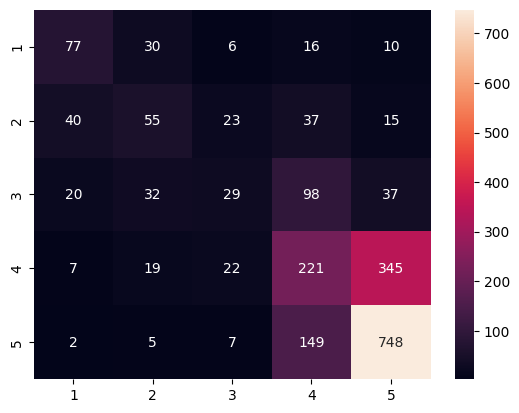

In [103]:
plot_confusion_matrix(y_test, y_pred)

In [104]:
# investigating the perfomence on the train set
y_train_pred = svc_simplest_input.predict(X_train)

In [105]:
accuracy_score(y_train, y_train_pred)

0.7247980044466136

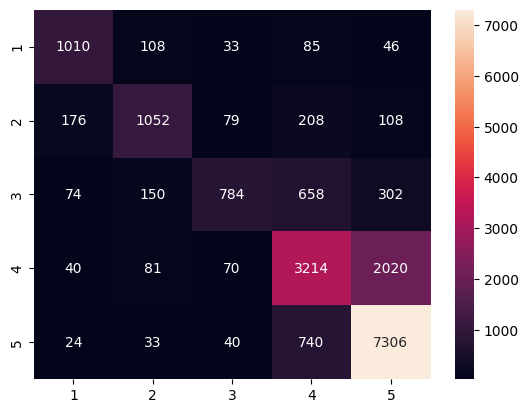

In [106]:
plot_confusion_matrix(y_train, y_train_pred)

### Classification with other parameters

#### Preparing train and test set

In [198]:
# reviews_for_classification['to_train'] = reviews_for_classification.apply(lambda row: row.doc2vec.extend([row.commas, row.words_number, row.average_length]), axis=1)

C:\Users\jjasi\AppData\Local\Temp\ipykernel_21704\2440993339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_for_classification['to_train'] = reviews_for_classification.apply(lambda row: row.doc2vec.extend([row.commas, row.words_number, row.average_length]), axis=1)


In [113]:
# creating a list of concatenated vectors
X = []

for _, row in reviews_for_classification.iterrows():
    x = row.doc2vec.copy()
    x.extend([row.words_number, row.commas, row.average_length])
    X.append(x)

len(X[0])

63

In [114]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, reviews_for_classification.Rating, 
                                                    test_size=0.1,
                                                    random_state=42)

In [116]:
len(X_train), len(y_train), len(X_test), len(y_test)

(18441, 18441, 2050, 2050)

In [117]:
# increasing C to weaken the L2 regularization
# at first the classifier was predicting only rating 5
svc_metadata = SVC(C=2)
svc_metadata.fit(X_train, y_train)

SVC(C=2)

#### Model evaluation

In [118]:
y_pred = svc_metadata.predict(X_test)

In [119]:
accuracy_score(y_test, y_pred)

0.6009756097560975

In [120]:
y_train_pred = svc_metadata.predict(X_train)

In [121]:
accuracy_score(y_train, y_train_pred)

0.8737595575077274

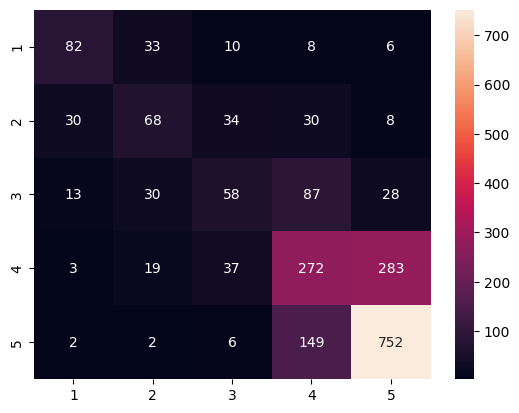

In [122]:
plot_confusion_matrix(y_test, y_pred)

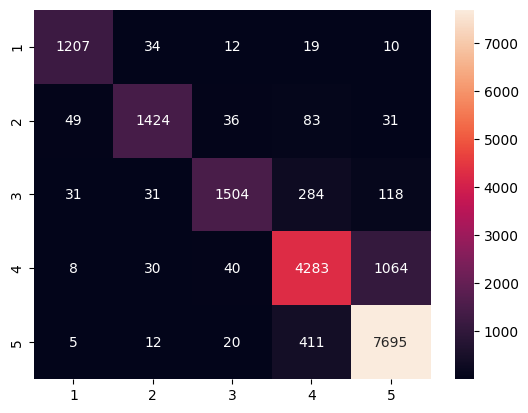

In [123]:
plot_confusion_matrix(y_train, y_train_pred)

The model with the extra inputs works slightly better so from now it will be just this one used

## KNeighbors

In [124]:
# since it is a very fast non-parametrical algorytm
# looking for best performing n_neighbours value
accuracies = []

for n_neighbours in range(1, 50):
    KNC = KNeighborsClassifier(n_neighbors=n_neighbours)
    KNC.fit(X_train, y_train)
    y_pred = KNC.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

In [125]:
best_n_neighbours = np.argmax(accuracies) + 1

In [126]:
KNC = KNeighborsClassifier(n_neighbors=best_n_neighbours)
KNC.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=26)

In [127]:
y_pred = KNC.predict(X_test)

In [128]:
accuracy_score(y_test, y_pred)

0.5341463414634147

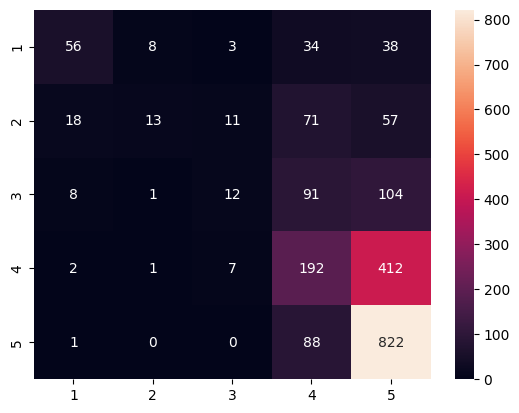

In [129]:
plot_confusion_matrix(y_test, y_pred)

In [130]:
y_train_pred = KNC.predict(X_train)

In [131]:
accuracy_score(y_train, y_train_pred)

0.5581584512770457

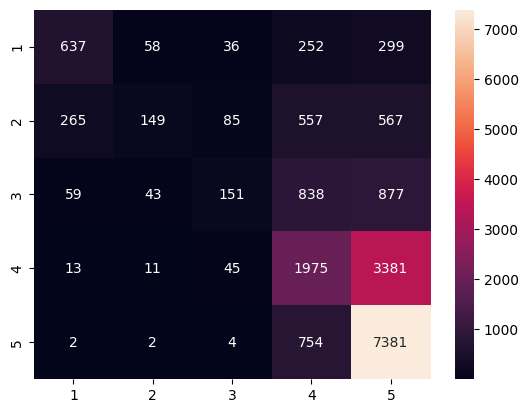

In [132]:
plot_confusion_matrix(y_train, y_train_pred)

## Random Forest

In [154]:
RFC = RandomForestClassifier(max_depth=14, random_state=42)

In [155]:
RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, random_state=42)

In [156]:
y_pred = RFC.predict(X_test)

In [157]:
accuracy_score(y_test, y_pred)

0.5287804878048781

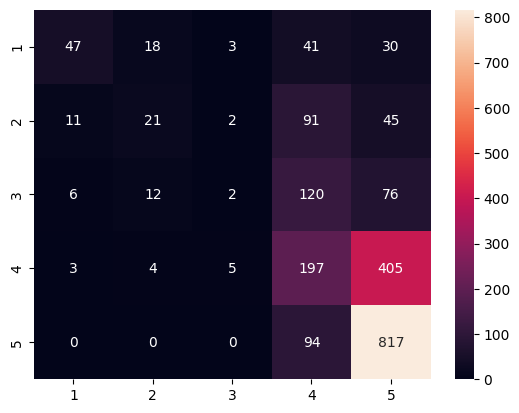

In [158]:
plot_confusion_matrix(y_test, y_pred)

In [159]:
y_train_pred = RFC.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9723984599533648

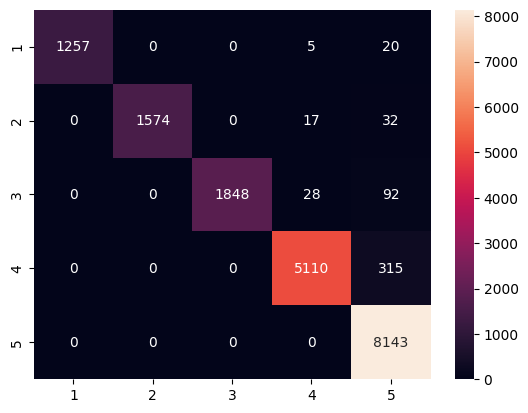

In [160]:
plot_confusion_matrix(y_train, y_train_pred)

## Linear SGD

In [161]:
SGD = SGDClassifier(loss='log_loss', alpha=1e-6, average=10)

In [162]:
SGD.fit(X_train, y_train)

SGDClassifier(alpha=1e-06, average=10, loss='log_loss')

In [163]:
y_pred = SGD.predict(X_test)

In [164]:
accuracy_score(y_test, y_pred)

0.6004878048780488

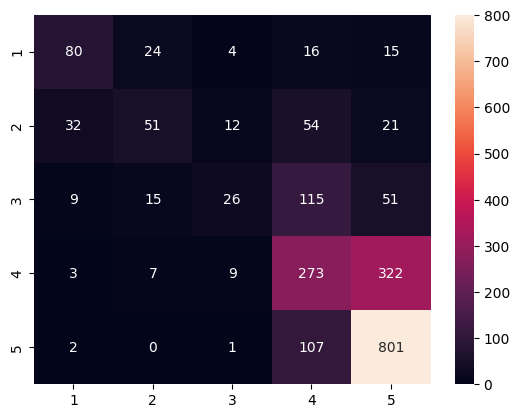

In [165]:
plot_confusion_matrix(y_test, y_pred)

In [166]:
y_train_pred = SGD.predict(X_train)

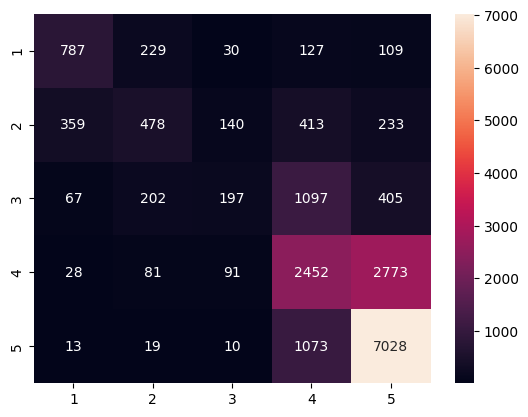

In [167]:
plot_confusion_matrix(y_train, y_train_pred)